In [1]:
import pandas as pd 
import sys 

sys.path.append('../../')
import helpers.data_helpers as data_helpers
import datetime
import pytz

In [ ]:
df = data_helpers.pickle_to_df('../../data/BTCUSDT_futures.pkl')

In [ ]:
short_df = df.loc['2022-01-01':'2024-01-01']

In [ ]:
db_value = 720_000_000

db_df = data_helpers.dollar_bar_func(short_df, db_value)

In [ ]:
db_df.to_csv('../../data/BTCUSDT_45mill.csv')

In [ ]:
db_df = pd.read_csv('../../data/BTCUSDT_90mill.csv')

In [ ]:
db_df['Close Time'] = pd.to_datetime(db_df['Close Time'])
db_df = db_df.set_index('Close Time')

In [ ]:
df = db_df.copy()

In [ ]:
df['duration'] = df.index.to_series().diff()
df['duration_minutes'] = df['duration'].dt.total_seconds() / 60
df['height'] = (df['High'] - df['Low']) / df['Open']


In [ ]:
#lets look at the average duration for each month. DB Sizing could 

start_time = datetime.datetime(year=2022, month=1, day=1).replace(tzinfo=pytz.timezone('UTC'))

jump = datetime.timedelta(days=30)

for i in range(24):
    df_slice = df.loc[start_time:start_time+jump].copy()

    

    avg_height = df_slice['duration_minutes'].mean()
    print(f"{start_time} : {avg_height}")
    start_time = start_time + jump

In [ ]:
#lets make a best indicator for each time period, then we can see how the best of each look against eachother
import time

# Define ranges for EMA and SMA windows
ema_range = range(2, 5)
sma_range = range(2, 30)

# Initialize variables to store optimal parameters and minimum ATR
optimal_ema_window = None
optimal_sma_window = None

min_avg_candle_height = float('inf')
min_group_avg_height = float('inf')
min_group_avg_std = float('inf')


avg_height = df['height'].mean()
# print(f"average height {avg_height}")
# Loop through parameter combinations
for ema_window in ema_range:
    for sma_window in sma_range:
        
        start = time.time()
        df_copy = df.copy()

        df_copy.loc[:, 'ema'] = df_copy['duration_minutes'].ewm(span=ema_window, adjust=False).mean()
        df_copy.loc[:, 'sma'] = df_copy['duration_minutes'].rolling(window=sma_window).mean()
        df_copy.loc[:, 'cross'] = None
        df_copy.loc[df_copy['ema'] < df_copy['sma'], 'cross'] = 1
        df_copy.loc[df_copy['ema'] > df_copy['sma'], 'cross'] = -1
        df_copy.loc[:, 'cross'] = df_copy['cross'].shift(1)
        df_copy = df_copy.dropna()
        df_copy.loc[:, 'crossover_group'] = (df_copy['cross'] != df_copy['cross'].shift(1)).cumsum()


        # print(f'checkpoint 1 {time.time() - start}')


        stats = df_copy.groupby(['crossover_group', 'cross']).agg({
            'duration_minutes': ['count', 'mean'],
            'Open': 'first',
            'Low': 'min',
            'High': 'max',
            'height': 'mean',
            'Close': lambda x: (x.pct_change()).std()
        }).reset_index().copy()


        # print(f'checkpoint 2 {time.time() - start}')
        hv_stats = stats[stats['cross'] == 1].copy()
        lv_stats = stats[stats['cross'] == -1].copy()

        lv_avg_candle_height = lv_stats['height'].mean().iloc[0]
        lv_stats.loc[:, ('group_height', '')] = (lv_stats[('High', 'max')] - lv_stats[('Low', 'min')] ) / lv_stats[('Open', 'first')]
        lv_avg_group_height = lv_stats['group_height'].mean()
        lv_avg_std = lv_stats['Close'].mean(skipna=True).iloc[0]

        print(f"Candle Height {round(lv_avg_candle_height, 5)} Group Height {round(lv_avg_group_height, 5)} Std {round(lv_avg_std, 5)}")


        if  lv_avg_candle_height < min_avg_candle_height :
            print(f"Average Height : Ema {ema_window} SMA {sma_window}")
        
            min_avg_candle_height = lv_avg_candle_height
            best_avg_candle_height = df_copy
        
        if  lv_avg_group_height < min_group_avg_height :
            print(f"Group Height : Ema {ema_window} SMA {sma_window}")
        
            min_group_avg_height = lv_avg_group_height
            best_avg_group_height = df_copy
        
        if  lv_avg_std < min_group_avg_std :
            print(f"Volatility : Ema {ema_window} SMA {sma_window}")
        
            min_group_avg_std = lv_avg_std
            best_avg_std = df_copy


In [ ]:
#avg height 2 10 3 29
#group height 2 10
#volatility 2 29
combos = [[4, 10], [10, 60], [20, 80], [30, 100], [20, 140], [50, 200]]
# combos = [[3, 26]] # the chosen one 
avg_height = df['height'].mean()
print(f"average height {avg_height}")
for combo in combos:
    ema_window = combo[0]
    sma_window = combo[1]


    df_copy = df.copy()

    df_copy.loc[:, 'ema'] = df_copy['duration_minutes'].ewm(span=ema_window, adjust=False).mean()
    df_copy.loc[:, 'sma'] = df_copy['duration_minutes'].rolling(window=sma_window).mean()
    df_copy.loc[:, 'cross'] = None
    df_copy.loc[df_copy['ema'] < df_copy['sma'], 'cross'] = 1
    df_copy.loc[df_copy['ema'] > df_copy['sma'], 'cross'] = -1
    df_copy.loc[:, 'cross'] = df_copy['cross'].shift(1)
    df_copy = df_copy.dropna()
    df_copy.loc[:, 'crossover_group'] = (df_copy['cross'] != df_copy['cross'].shift(1)).cumsum()


    # print(f'checkpoint 1 {time.time() - start}')


    stats = df_copy.groupby(['crossover_group', 'cross']).agg({
        'duration_minutes': ['count', 'mean'],
        'Open': 'first',
        'Low': 'min',
        'High': 'max',
        'height': 'mean',
        'Close': lambda x: (x.pct_change()).std()
    }).reset_index().copy()


    # print(f'checkpoint 2 {time.time() - start}')
    hv_stats = stats[stats['cross'] == -1].copy()
    lv_stats = stats[stats['cross'] == 1].copy()

    lv_avg_candle_height = lv_stats['height'].mean().iloc[0]
    lv_stats.loc[:, ('group_height', '')] = (lv_stats[('High', 'max')] - lv_stats[('Low', 'min')] ) / lv_stats[('Open', 'first')]
    lv_avg_group_height = lv_stats['group_height'].mean()
    lv_avg_std = lv_stats['Close'].mean(skipna=True).iloc[0]

    print(f"Candle Height {round(lv_avg_candle_height, 5)} Group Height {round(lv_avg_group_height, 5)} Std {round(lv_avg_std, 5)}")

    best_sample = df_copy
    # if  lv_avg_candle_height < min_avg_candle_height :
    #     print(f"Average Height : Ema {ema_window} SMA {sma_window}")

    #     min_avg_candle_height = lv_avg_candle_height
    #     best_avg_candle_height = df_copy

    # if  lv_avg_group_height < min_group_avg_height :
    #     print(f"Group Height : Ema {ema_window} SMA {sma_window}")

    #     min_group_avg_height = lv_avg_group_height
    #     best_avg_group_height = df_copy

    # if  lv_avg_std < min_group_avg_std :
    #     print(f"Volatility : Ema {ema_window} SMA {sma_window}")

    #     min_group_avg_std = lv_avg_std
    #     best_avg_std = df_copy
    import matplotlib.pyplot as plt
    import numpy as np

    start = '2023-03-15'
    end = '2023-4-01'

    plot_sample = best_sample.loc[start:end].copy()
    # plot_sample['cross'] = plot_sample['cross'].shift(1)


    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Close'], None)
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None)

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title(f'[{ema_window}, {sma_window}]')
    plt.legend()

    # Display the plot
    plt.show()
    # print(plot_sample.to_markdown())

In [ ]:
"""
Rankings 
They all look good on 50, 200 

90 mill 50, 200
180 Mill 3, 29
360 20, 80 20, 140
"""

In [4]:
#lets look at all of them on the 50, 200

db_90 = pd.read_csv('../../data/BTCUSDT_90mill.csv')
db_180 = pd.read_csv('../../data/BTCUSDT_180mill.csv')
db_360 = pd.read_csv('../../data/BTCUSDT_360mill.csv')
db_720 = pd.read_csv('../../data/BTCUSDT_720mill.csv')

dbs = [db_90, db_180, db_360, db_720]

In [5]:
for i in range(len(dbs)):
    dbs[i]['Close Time'] = pd.to_datetime(dbs[i]['Close Time'])
    dbs[i] = dbs[i].set_index('Close Time')

    dbs[i]['duration'] = dbs[i].index.to_series().diff()
    dbs[i]['duration_minutes'] = dbs[i]['duration'].dt.total_seconds() / 60
    dbs[i]['height'] = (dbs[i]['High'] - dbs[i]['Low']) / dbs[i]['Open']

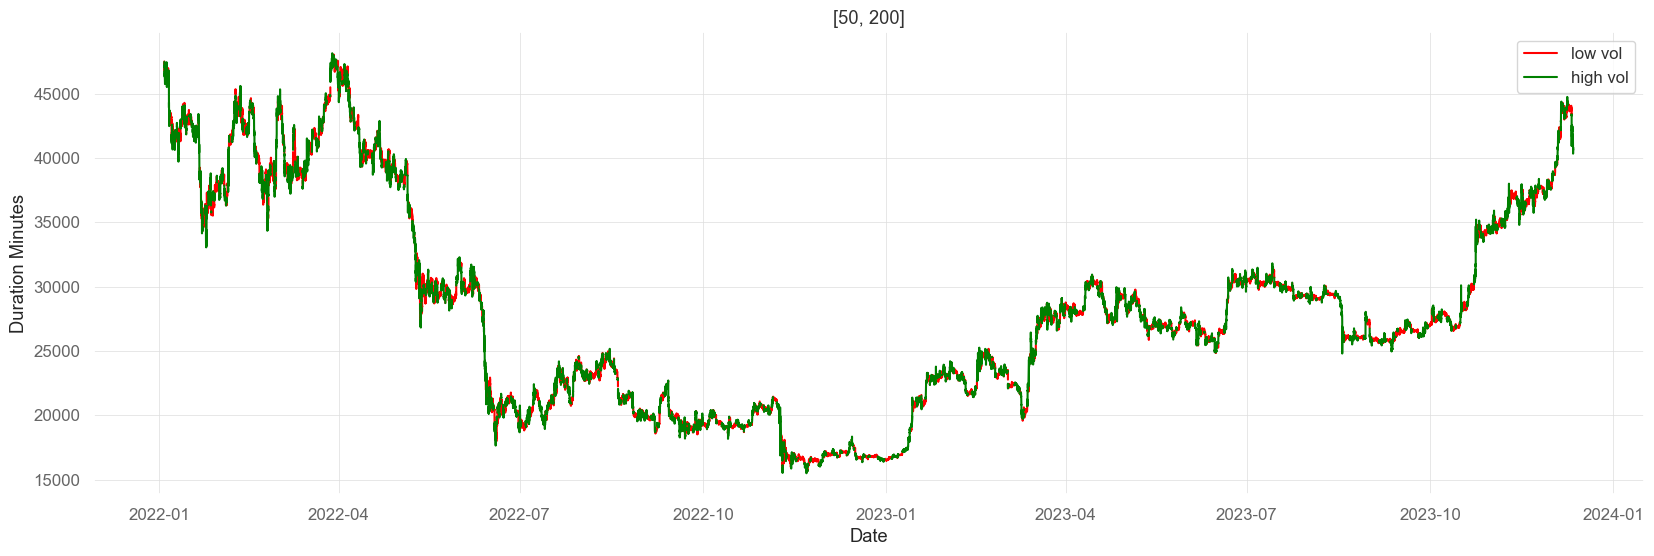

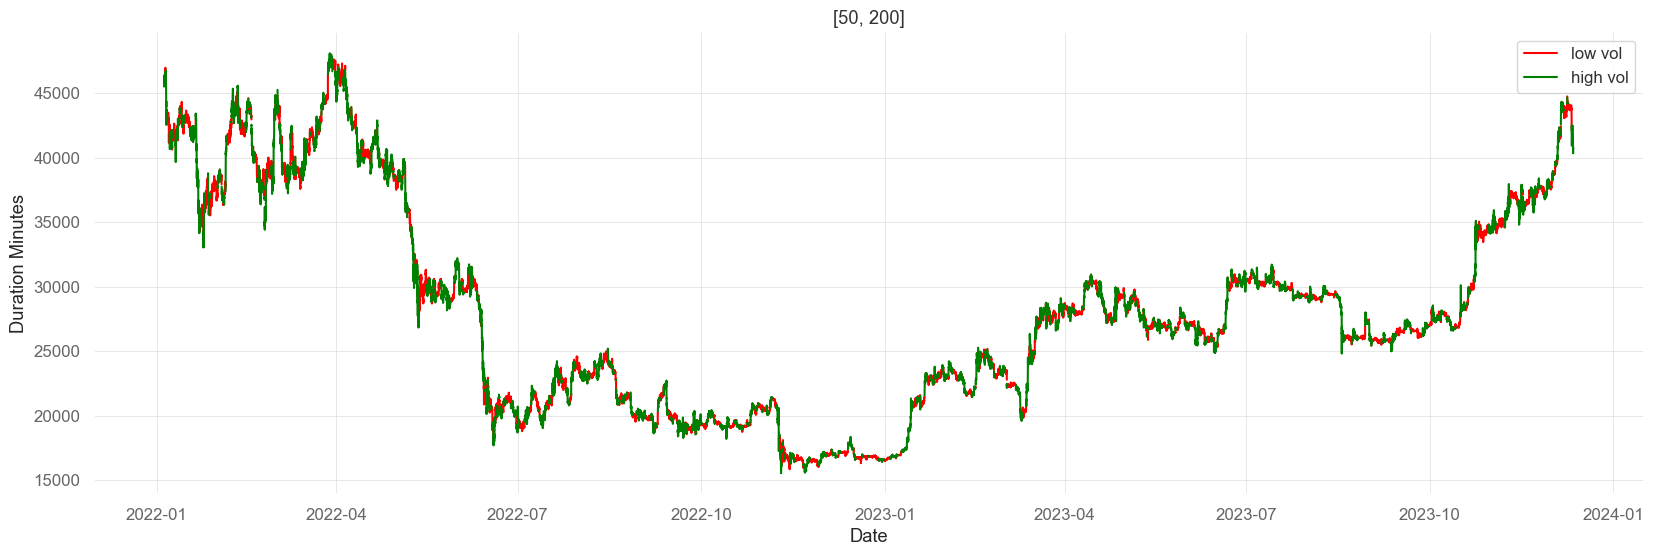

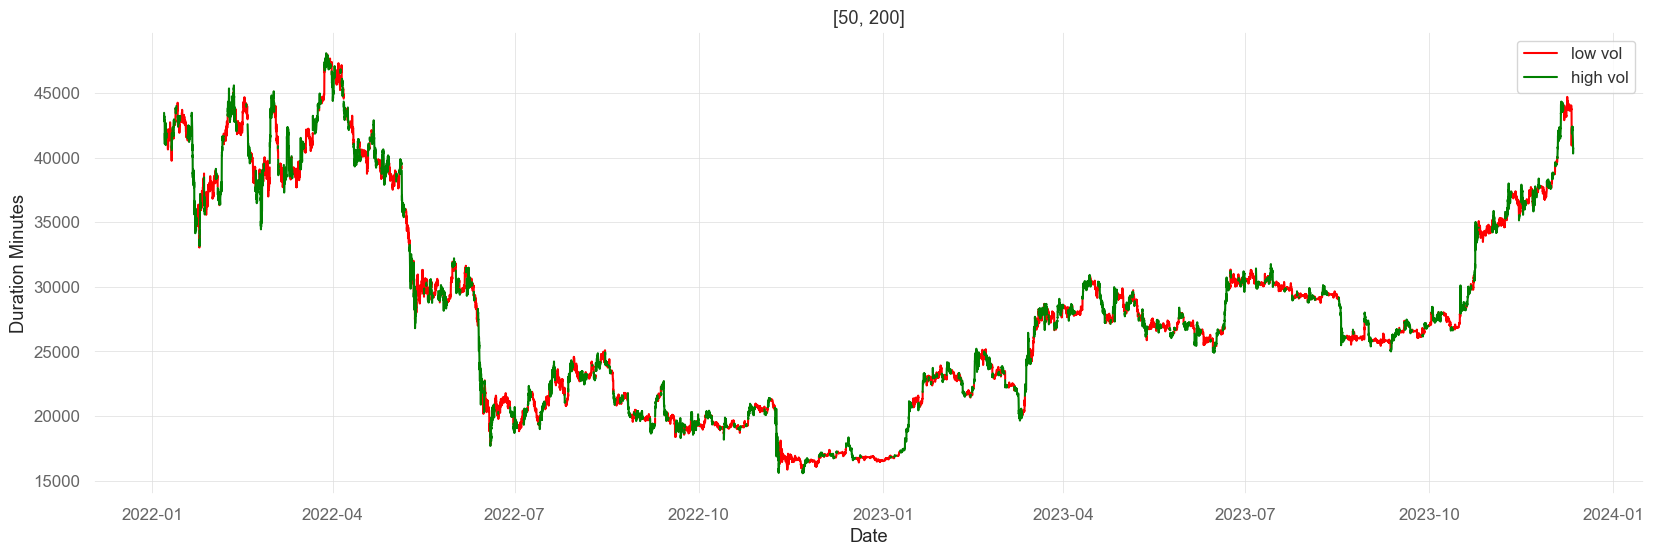

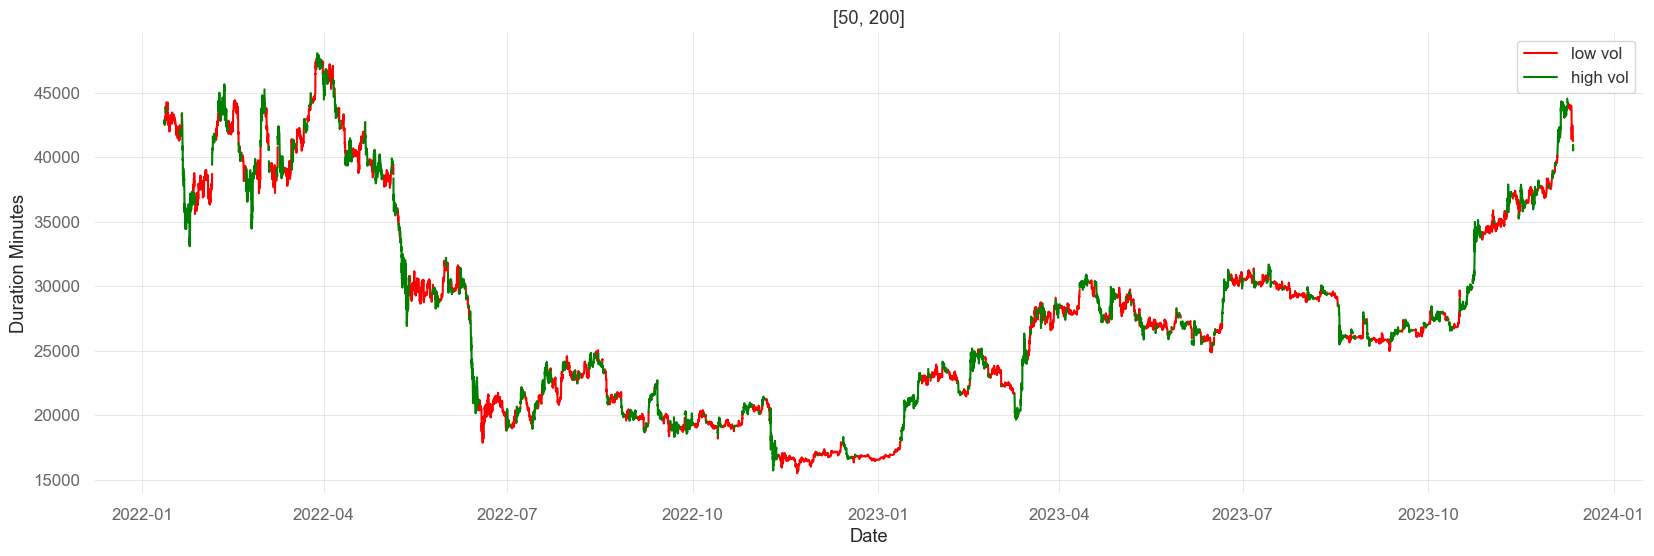

In [6]:
import numpy as np
import matplotlib.pyplot as plt

ema_window = 50
sma_window = 200

start = '2022-01-01'
end = '2024-03-01'

modeled_dfs = []

for db in dbs:


    df_copy = db.copy()

    df_copy.loc[:, 'ema'] = df_copy['duration_minutes'].ewm(span=ema_window, adjust=False).mean()
    df_copy.loc[:, 'sma'] = df_copy['duration_minutes'].rolling(window=sma_window).mean()
    df_copy.loc[:, 'cross'] = None
    df_copy.loc[df_copy['ema'] < df_copy['sma'], 'cross'] = 1
    df_copy.loc[df_copy['ema'] > df_copy['sma'], 'cross'] = -1
    df_copy.loc[:, 'cross'] = df_copy['cross'].shift(1)

    best_sample = df_copy
    

    plot_sample = best_sample.loc[start:end].copy()
    modeled_dfs.append(plot_sample)

    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Close'], None)
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None)

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title(f'[{ema_window}, {sma_window}]')
    plt.legend()
    # Display the plot
    plt.show()



In [7]:
for i in range(len(modeled_dfs)):
    modeled_dfs[i]['Open Time'] = pd.to_datetime(modeled_dfs[i]['Open Time'])

In [ ]:
"""
lets overlay all the green, so that way we reduce red blips in the high vol periods.
Pros/Cons. Smooths out green area. We could do this the opposite way and overlay the reds. But I think we want to be more careful about the greens 
this way we should catch a green move as fast as possible. This means we will have some green blips in red, which we would want to exit the market in a low 
vol strategy, but thats just false exits. This way we don't enter in a low vol period and it ends up not being a low vol period. 
"""


overlay_green = modeled_dfs[0].copy()
overlay_green_only_red = overlay_green[overlay_green['cross'] == -1]



for index, row in overlay_green_only_red.iterrows():

    # print(f"index {index}")
    for i in range(1):
        temp_df  = modeled_dfs[1+i]
        last_row = temp_df[temp_df['Open Time'] < index].iloc[-1]
        
        if last_row.cross == 1:
            overlay_green.at[index, 'cross'] = 1
            print(f"Model {i+1} is green")
            break
        
overlay_red = modeled_dfs[0].copy()
overlay_red_only_green = overlay_red[overlay_red['cross'] == 1]

for index, row in overlay_red_only_green.iterrows():

    # print(f"index {index}")
    for i in range(1):
        temp_df  = modeled_dfs[1+i]
        last_row = temp_df[temp_df['Open Time'] < index].iloc[-1]
        
        if last_row.cross == 1:
            overlay_red.at[index, 'cross'] = 1
            print(f"Model {i+1} is green")
            break
    
    


In [ ]:
start = '2023-02-09'
end = '2023-02-10'



plot_sample = overlay_green.loc[start:end].copy()
modeled_dfs.append(plot_sample)
base_value = 100
plot_sample['Normalized Price'] = plot_sample['Close'] / plot_sample['Close'].iloc[0] * base_value

plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Normalized Price'], None)
plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Normalized Price'], None)

# Plot the Close, SMA, and EMA
plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
# plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
# plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
# plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title(f'[{ema_window}, {sma_window}]')
plt.legend()
# Display the plot
plt.show()

plot_sample = overlay_red.loc[start:end].copy()
modeled_dfs.append(plot_sample)
base_value = 100
plot_sample['Normalized Price'] = plot_sample['Close'] / plot_sample['Close'].iloc[0] * base_value

plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Normalized Price'], None)
plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Normalized Price'], None)

# Plot the Close, SMA, and EMA
plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
# plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
# plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
# plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title(f'[{ema_window}, {sma_window}]')
plt.legend()
# Display the plot
plt.show()

In [ ]:
#I think the 90 mill vol is good enough

minute_candles = data_helpers.pickle_to_df('../../data/BTCUSDT_futures.pkl')

minute_candles = minute_candles.loc['2022-01-01':'2024-01-01']

vol_df = modeled_dfs[0].copy()

vol_df = vol_df.dropna()

def map_volatility(row):
    # Find rows in df_volatility where the open time of the candle falls between the open and close time of the volatility period
    vol_row = vol_df[(vol_df['Open Time'] <= row.name) & (vol_df.index > row.name)]
    if not vol_row.empty:
        return vol_row.iloc[0]['cross'] # Assuming 'Volatility' is the column name in df_volatility
    else:
        return None # or a default value
    
testing_minute = minute_candles.copy()

testing_minute['cross'] = testing_minute.apply(map_volatility, axis=1)

In [25]:
merged_dfs = []

# for i in range(len(modeled_dfs)):
i = 3
vol_df = modeled_dfs[i].copy()
vol_df = vol_df.reset_index()
vol_df_reduced = vol_df[['Close Time', 'Open Time', 'cross']].copy()
vol_df_reduced = vol_df_reduced.dropna()
vol_df_reduced['Close Time'] =  vol_df_reduced['Close Time'].dt.round('1min')

candles_df = minute_candles.copy()

candles_df = candles_df.reset_index()
candles_df = candles_df.rename(columns={'datetime': 'Open Time'})
candles_df['Open Time'] = pd.to_datetime(candles_df['Open Time'])

# Convert all timestamps to UTC or make them tz-naive
candles_df['Open Time'] = candles_df['Open Time'].dt.tz_convert(None)
vol_df_reduced['Open Time'] = vol_df_reduced['Open Time'].dt.tz_convert(None)
vol_df_reduced['Close Time'] = vol_df_reduced['Close Time'].dt.tz_convert(None)

# Re-do the merge_asof if needed
merged_df = pd.merge_asof(candles_df, vol_df_reduced, left_on='Open Time', right_on='Open Time', direction='forward')

# Create the dictionary for the Close Time lookup
close_time_dict = dict(zip(vol_df_reduced['Open Time'], vol_df_reduced['Close Time']))

# Filter out incorrect matches using the Close Time
merged_df['cross'] = merged_df.apply(lambda row: row['cross'] if row['Open Time'] <= close_time_dict.get(row['Open Time'], pd.Timestamp.max) else None, axis=1)

# Set 'Open Time' as the index if required
merged_df.set_index('Open Time', inplace=True)
# merged_dfs.append(merged_df)



In [26]:

merged_df.to_csv('../../data/vol_models/BTCUSDT_720mill.csv')

C:\Users\cyrus\AppData\Local\Temp\ipykernel_9300\739933974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])


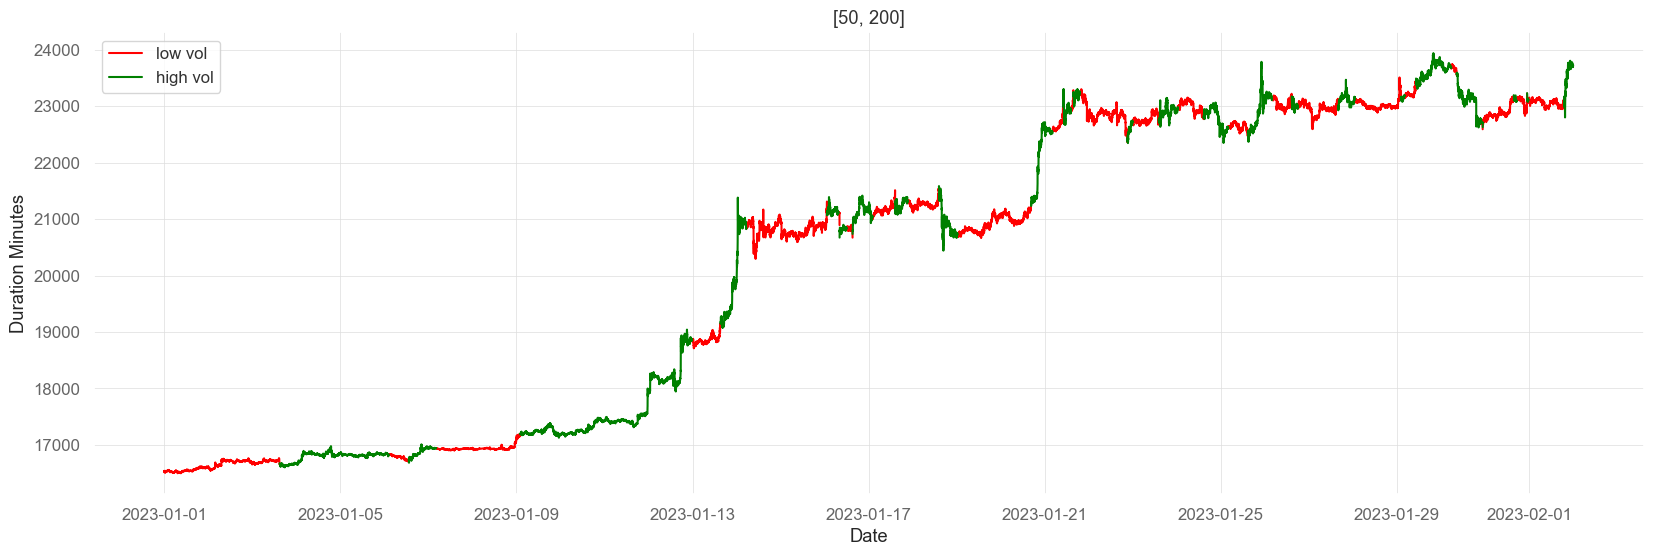

C:\Users\cyrus\AppData\Local\Temp\ipykernel_9300\739933974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])


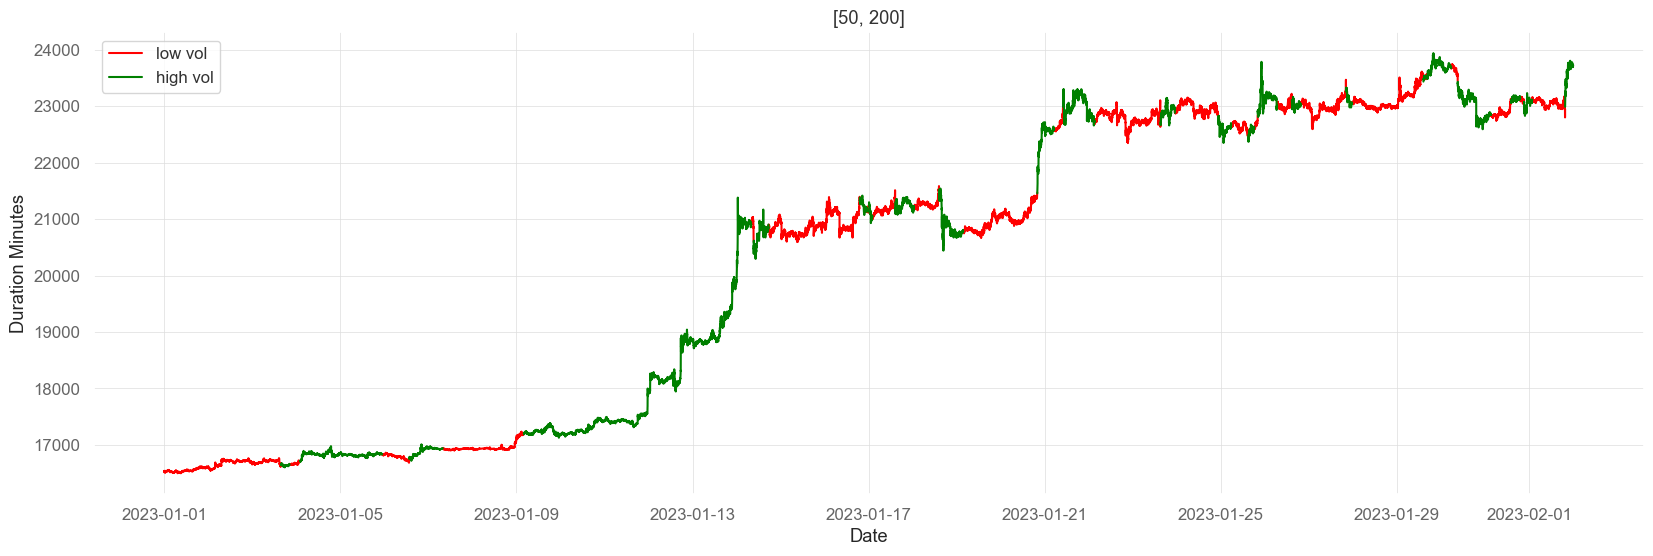

C:\Users\cyrus\AppData\Local\Temp\ipykernel_9300\739933974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])


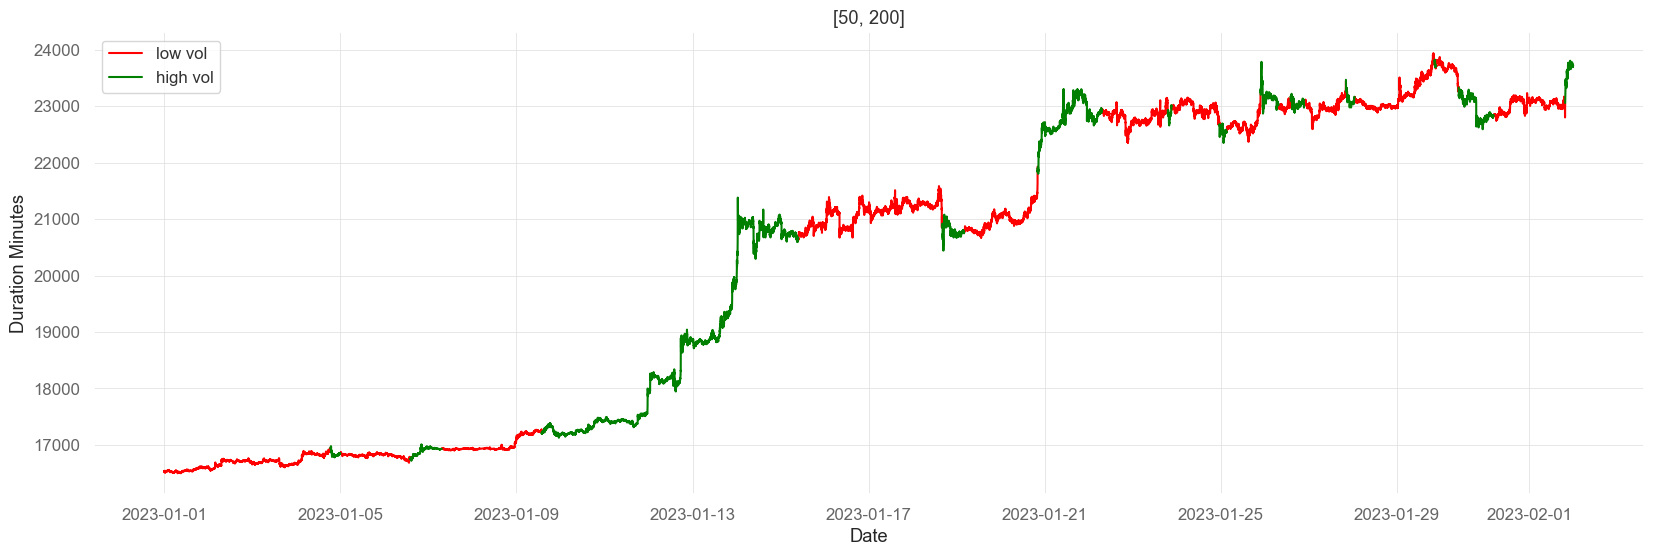

C:\Users\cyrus\AppData\Local\Temp\ipykernel_9300\739933974.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])


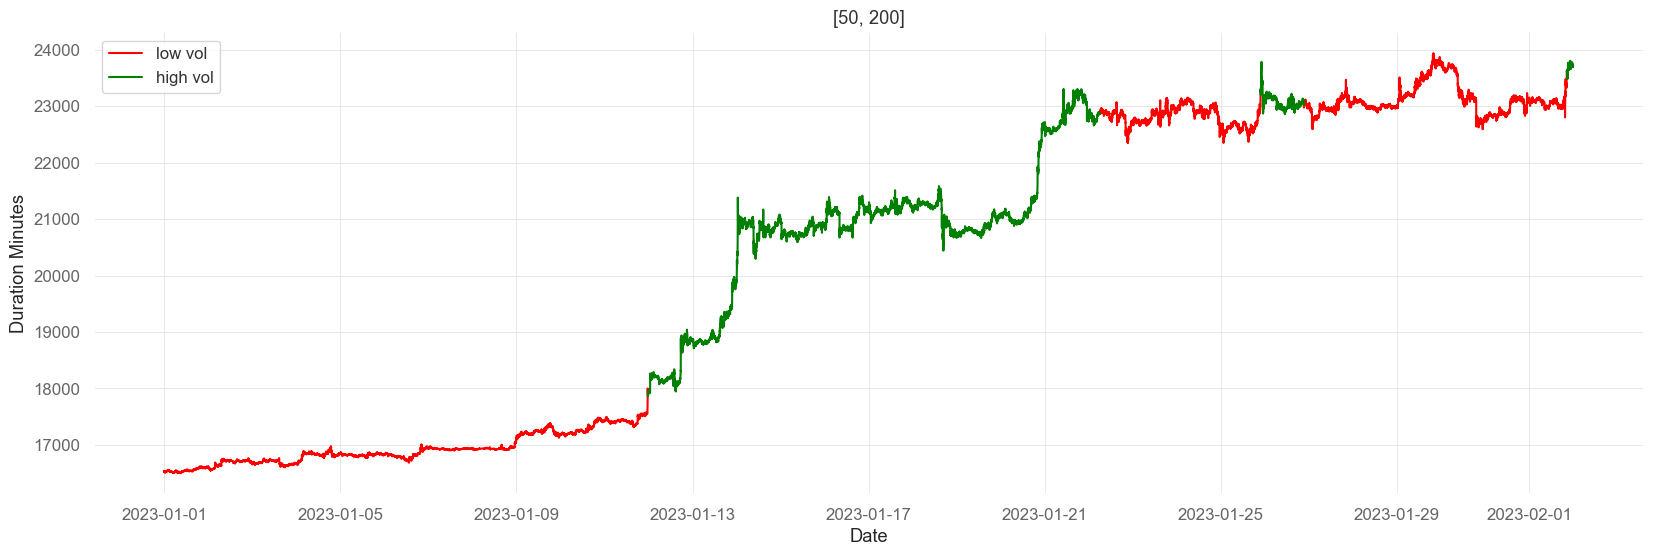

In [41]:
vol_model_90 = pd.read_csv("../../data/vol_models/BTCUSDT_90mill.csv")
vol_model_180 = pd.read_csv("../../data/vol_models/BTCUSDT_180mill.csv")
vol_model_360 = pd.read_csv("../../data/vol_models/BTCUSDT_360mill.csv")
vol_model_720 = pd.read_csv("../../data/vol_models/BTCUSDT_720mill.csv")


vol_models = [vol_model_90, vol_model_180, vol_model_360, vol_model_720]
# print(vol_model_90)
start = '2023-01-01'
end = '2023-02-01'

for vol_model in vol_models:
    vol_model = vol_model.dropna()
    vol_model['Open Time'] = pd.to_datetime(vol_model['Open Time'])
    vol_model = vol_model.set_index('Open Time')
    
    
    
    plot_sample = vol_model.loc[start:end].copy()
    modeled_dfs.append(plot_sample)

    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1, plot_sample['Close'], None)
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None)

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title(f'[{ema_window}, {sma_window}]')
    plt.legend()
    # Display the plot
    plt.show()



                   Open Time      Open      High       Low     Close   Volume  \
0        2022-01-01 00:00:00  46210.57  46265.41  46210.55  46246.66  253.757   
1        2022-01-01 00:01:00  46246.66  46335.17  46235.80  46314.36  275.296   
2        2022-01-01 00:02:00  46311.81  46385.40  46283.01  46367.54  304.721   
3        2022-01-01 00:03:00  46367.54  46390.83  46305.61  46328.00  182.410   
4        2022-01-01 00:04:00  46327.99  46332.59  46292.18  46316.17   64.906   
...                      ...       ...       ...       ...       ...      ...   
1022196  2023-12-11 20:36:00  40663.80  40672.50  40623.40  40665.60  194.250   
1022197  2023-12-11 20:37:00  40665.70  40728.80  40655.70  40715.90  302.775   
1022198  2023-12-11 20:38:00  40716.10  40716.10  40688.60  40702.10  260.268   
1022199  2023-12-11 20:39:00  40702.00  40742.10  40682.80  40682.80  291.341   
1022200  2023-12-11 20:40:00  40682.80  40691.40  40646.80  40691.40  177.998   

                  Close Tim

In [79]:
"""
Lets do position manager entry style. And you enter in a red period, exit when it turns green 
You enter long or short based off 20 period and 50 period SMA (on 4 hour candles) 4800 min and 12000
Lets start with regular position manager 80 bps down and then add 1/6 1/3 1/2 or maybe we do less initial 
Next step could be changing the 80 bps to something market determined
"""
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    TRADE_SIZES = {0: .5, 1: .166, 2: .4, 3: .99, 4:0}

    TP= .003
    ADD_THRESH = -.008
    MAX_TRADES = 4
    n1 = 4800
    n2 = 12000
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        # self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if not self.position:

            if self.vol[-1] == -1:
                if self.sma1 > self.sma2:
                    self.buy(size=self.TRADE_SIZES[0])
                else:
                    self.sell(size=self.TRADE_SIZES[0])
        
        if self.position:
            # print(f'Last Trade {self.trades[-1].pl_pct} Add Thresh {self.ADD_THRESH}')
            if self.vol[-1] == 1:
                self.position.close()
            
            
            elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) < self.MAX_TRADES:

                print('ADDING BTICH')

                if self.position.is_long:
                    self.buy(size=self.TRADE_SIZES[len(self.trades)])
                else:
                    self.sell(size=self.TRADE_SIZES[len(self.trades)])
            
            elif self.position.pl_pct > self.TP:
                self.position.close()
    
        

bt_start = '2023-01-01'
bt_end = '2023-04-01'

bt_data = vol_models[0].copy()
bt_data['Open Time'] = pd.to_datetime(bt_data['Open Time'])
bt_data = bt_data.set_index('Open Time')

print(bt_data.loc[bt_start:bt_end])
bt = Backtest(
    bt_data.loc[bt_start:bt_end],
    PMvol,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=.5,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)
    

                        Open     High      Low    Close   Volume  \
Open Time                                                          
2023-01-01 00:00:00  16537.5  16538.0  16534.3  16538.0  170.576   
2023-01-01 00:01:00  16538.0  16538.0  16534.9  16534.9   44.287   
2023-01-01 00:02:00  16534.9  16535.0  16531.3  16531.4  100.228   
2023-01-01 00:03:00  16531.4  16531.4  16526.6  16526.9  317.879   
2023-01-01 00:04:00  16527.0  16529.3  16523.0  16529.2  211.281   
...                      ...      ...      ...      ...      ...   
2023-04-01 23:55:00  28448.1  28448.2  28448.0  28448.0   33.657   
2023-04-01 23:56:00  28448.1  28448.1  28433.2  28441.9  116.353   
2023-04-01 23:57:00  28441.9  28441.9  28441.8  28441.8   38.089   
2023-04-01 23:58:00  28441.9  28441.9  28435.0  28439.0   76.966   
2023-04-01 23:59:00  28439.0  28443.8  28435.3  28443.8   90.846   

                              Close Time  cross  
Open Time                                        
2023-01-01 00:0

In [73]:
trade_analysis = bt_data.copy()
trade_analysis['long_entries'] = None
trade_analysis['long_exits'] = None
trade_analysis['short_entries'] = None
trade_analysis['short_exits'] = None

for index, row in stat['_trades'].iterrows():
    if row['Size'] > 0:
        trade_analysis.at[row['EntryTime'], 'long_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'long_exits'] = row['ExitPrice']
    if row['Size'] < 0:
        trade_analysis.at[row['EntryTime'], 'short_entries'] = row['EntryPrice']
        trade_analysis.at[row['ExitTime'], 'short_exits'] = row['ExitPrice']

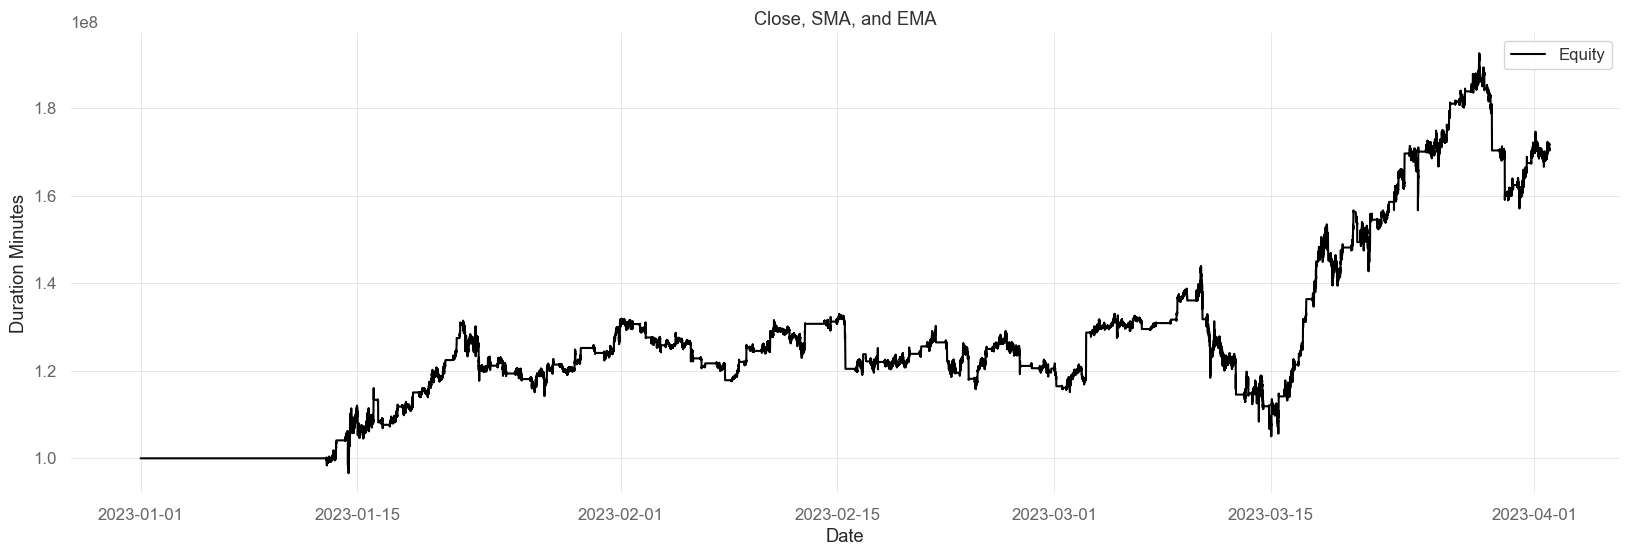

In [78]:
# print(stat['_trades'].to_markdown())

# Plot the Close, SMA, and EMA
eq_curve = stat['_equity_curve'] 

plt.figure(figsize=(20, 6))
plt.plot(eq_curve.index, eq_curve['Equity'], label='Equity', color = 'black')


# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title('Close, SMA, and EMA')
plt.legend()

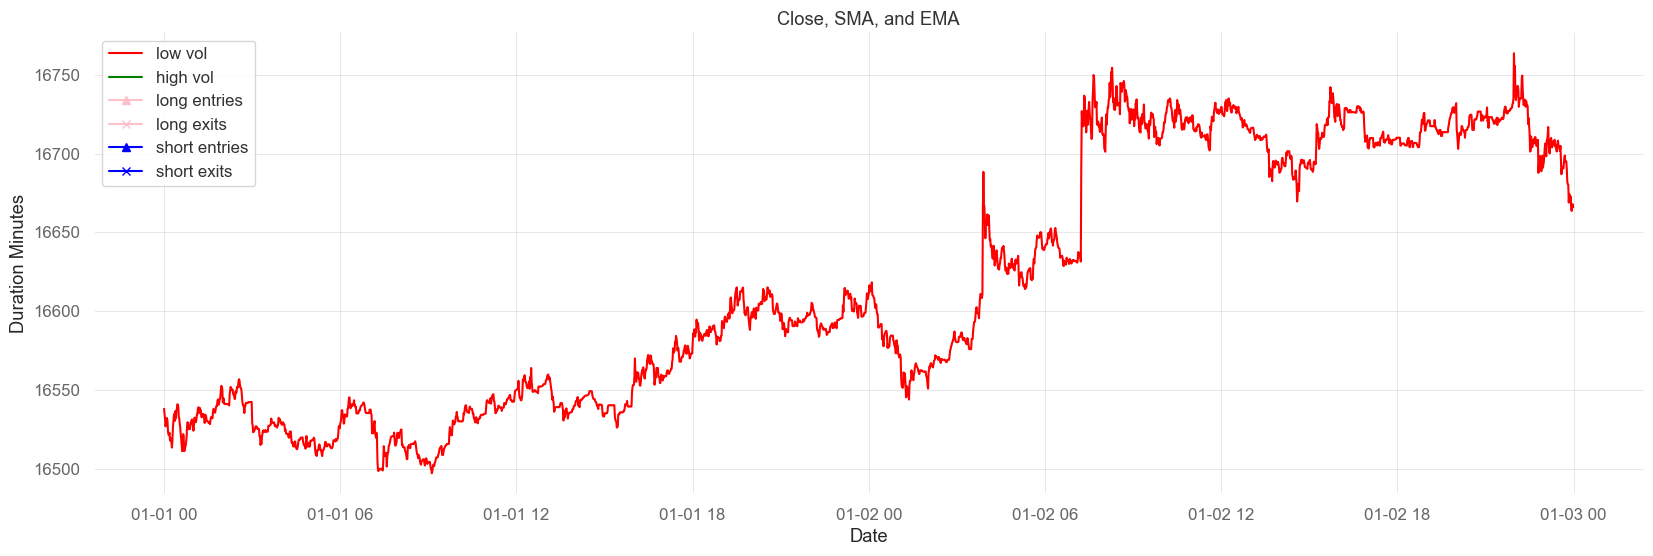

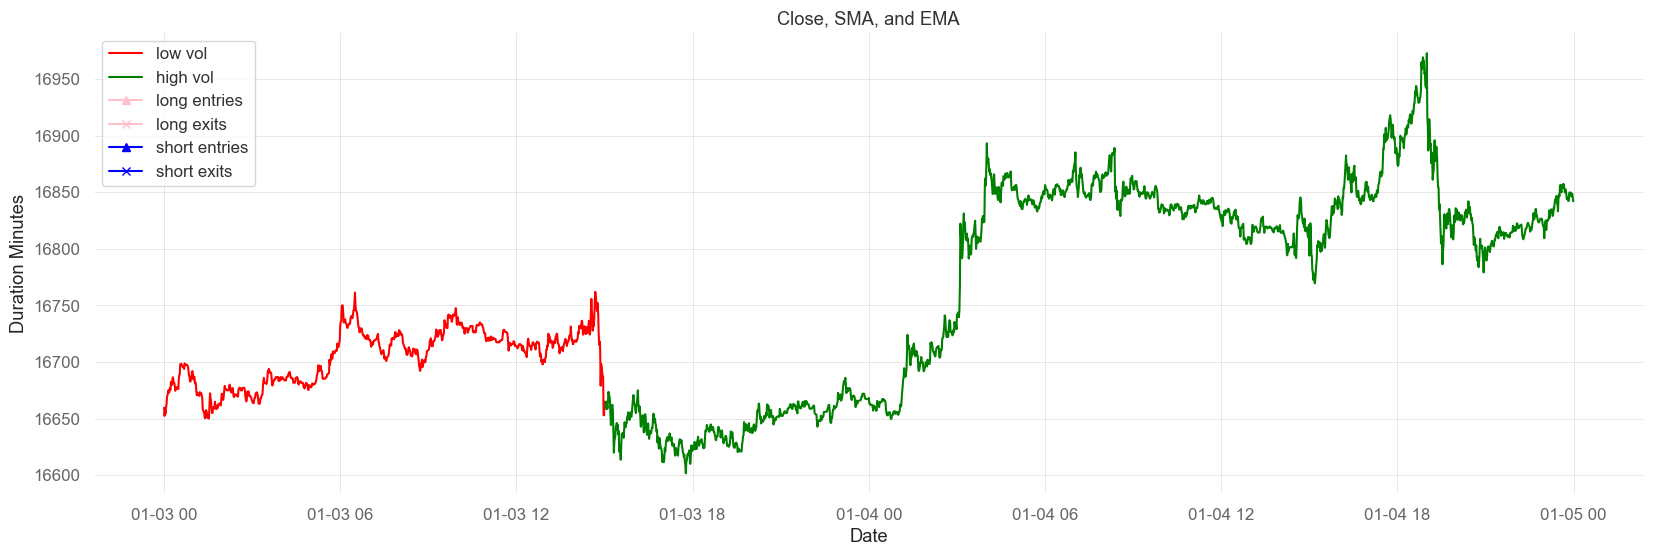

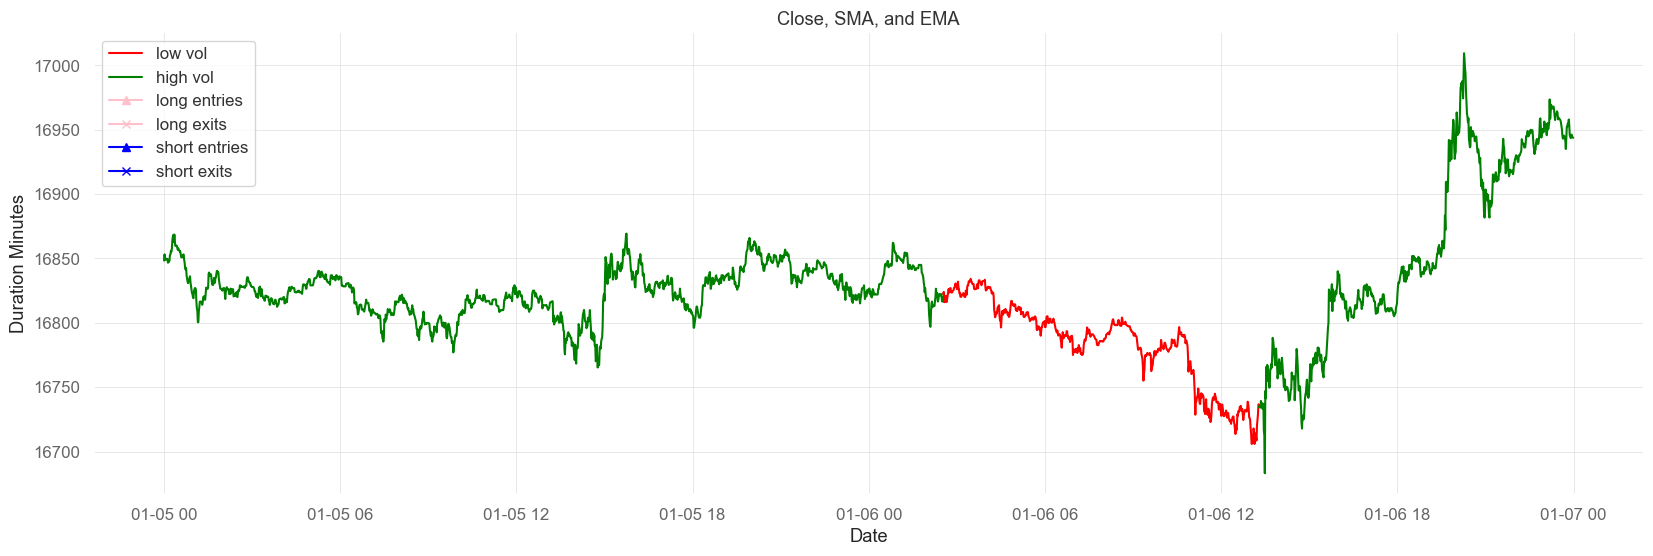

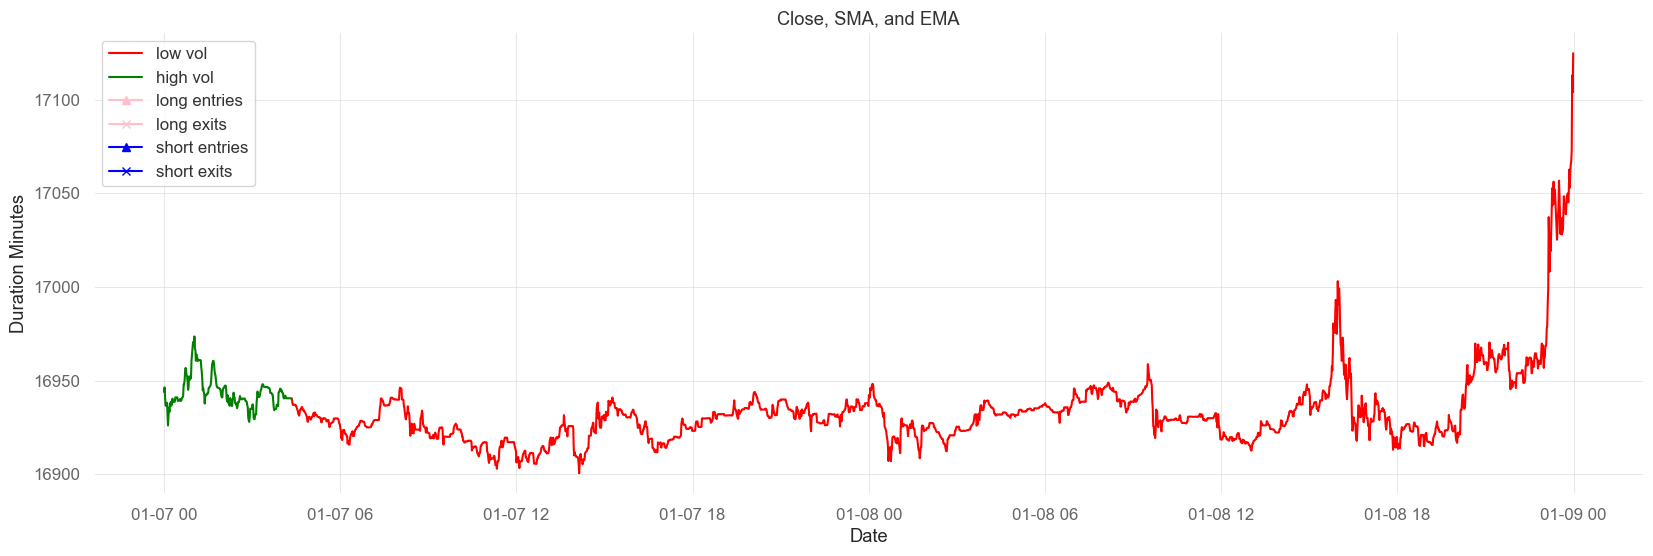

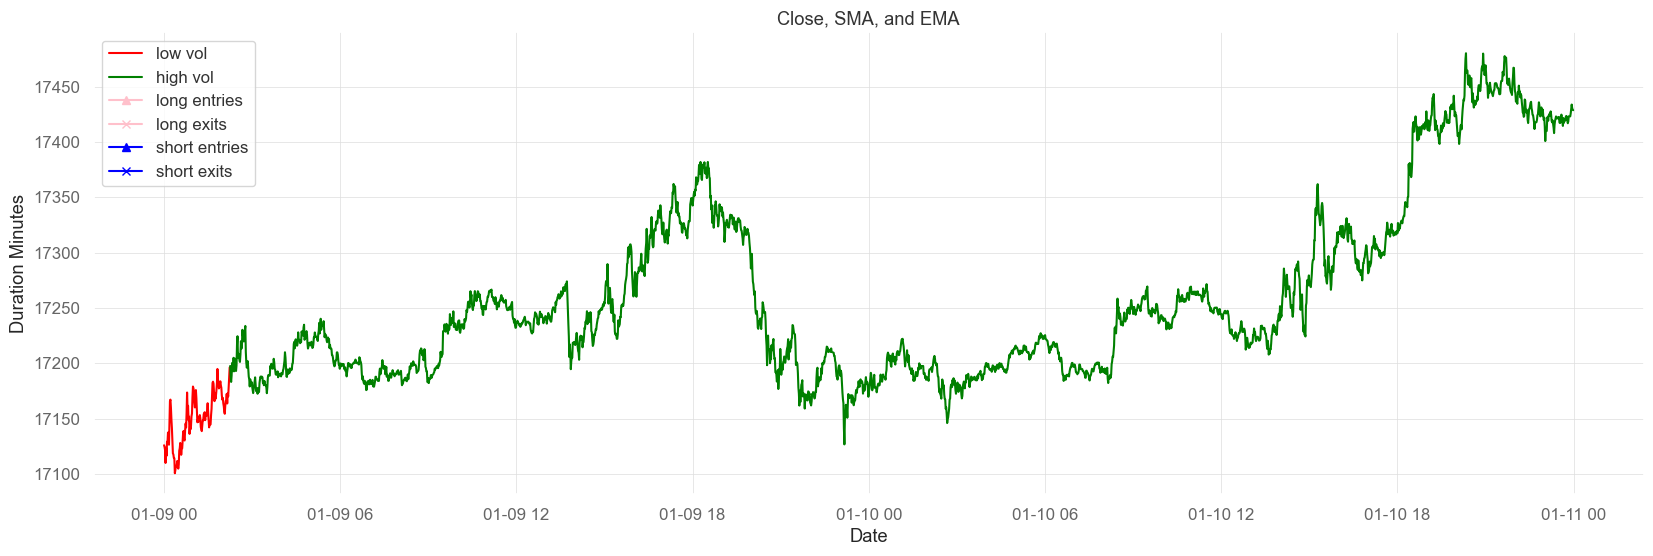

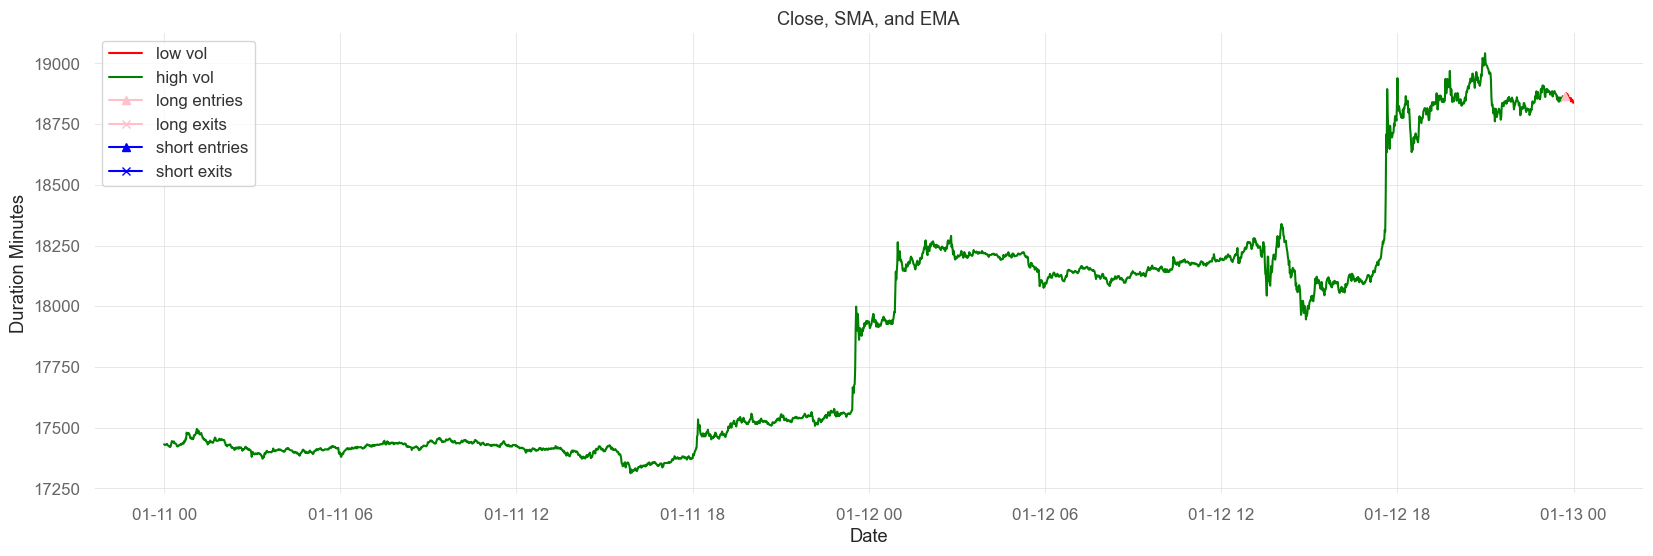

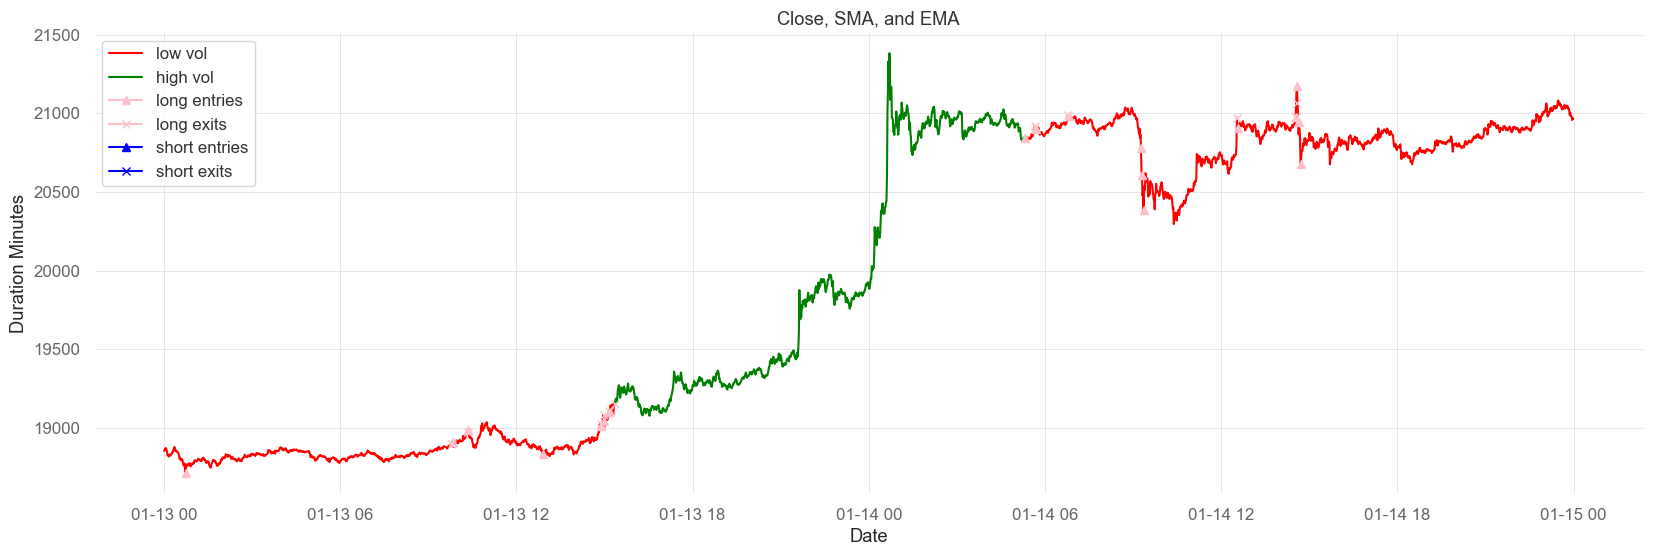

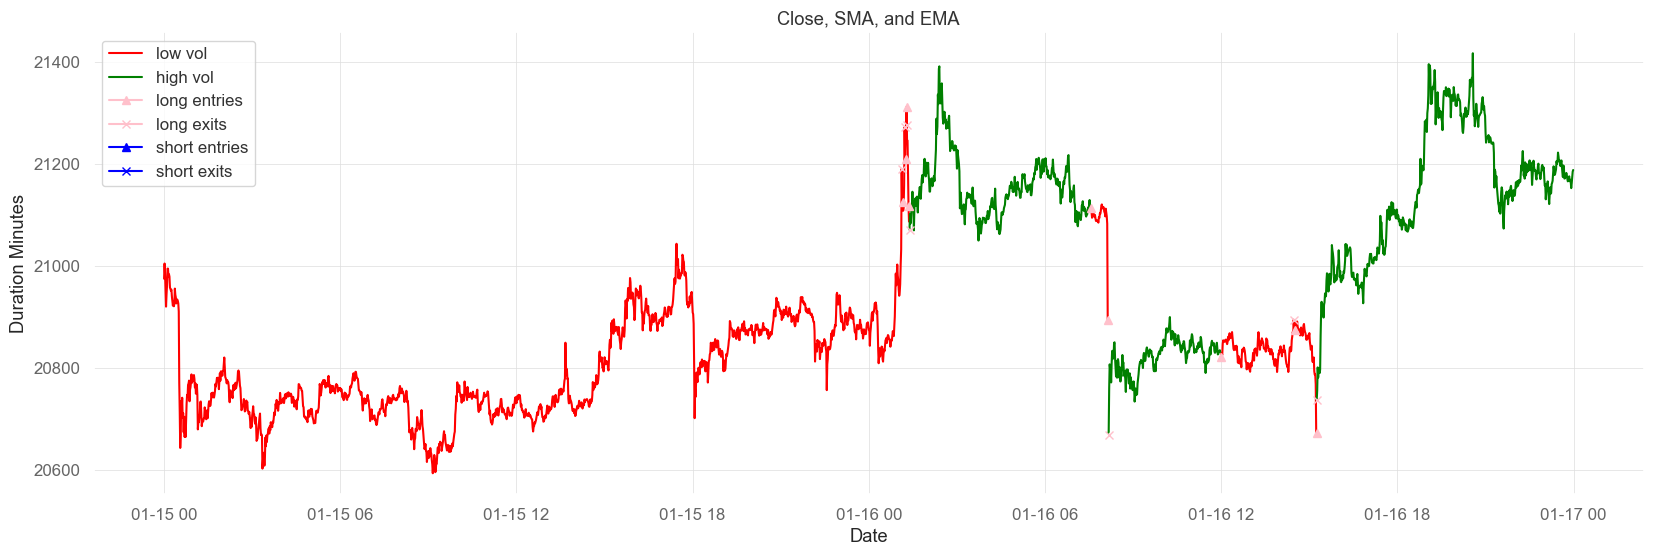

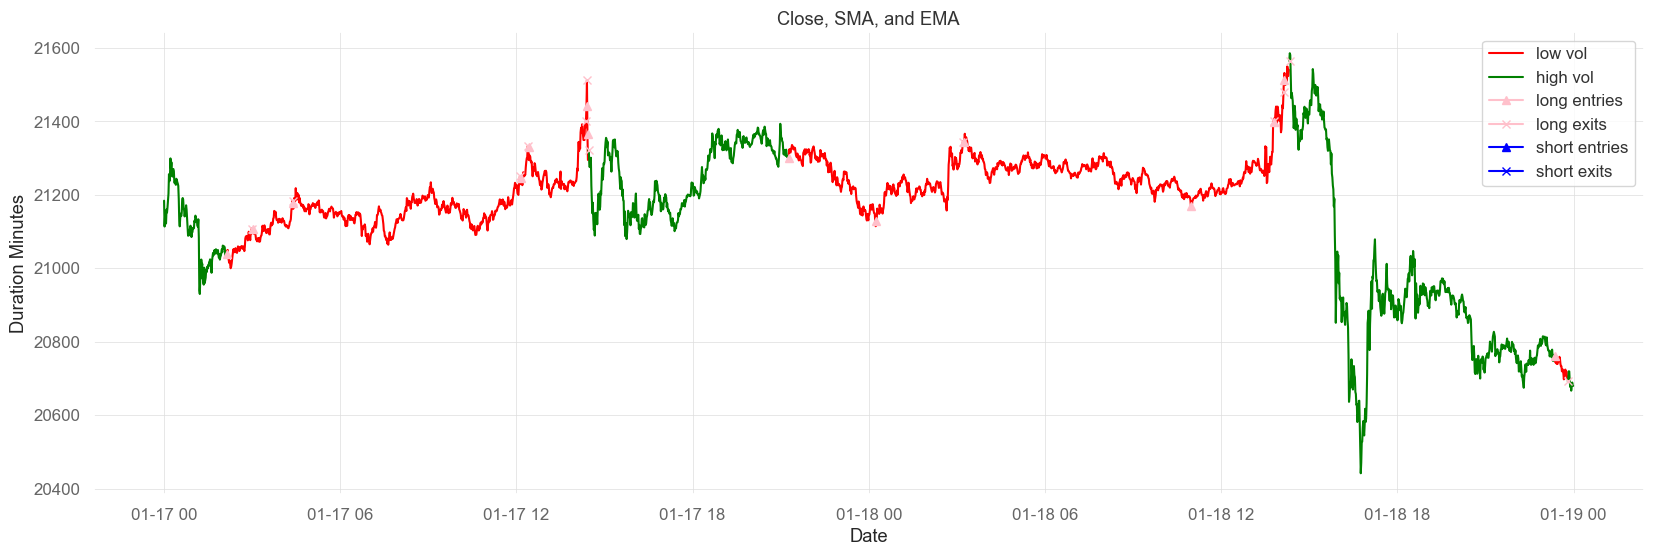

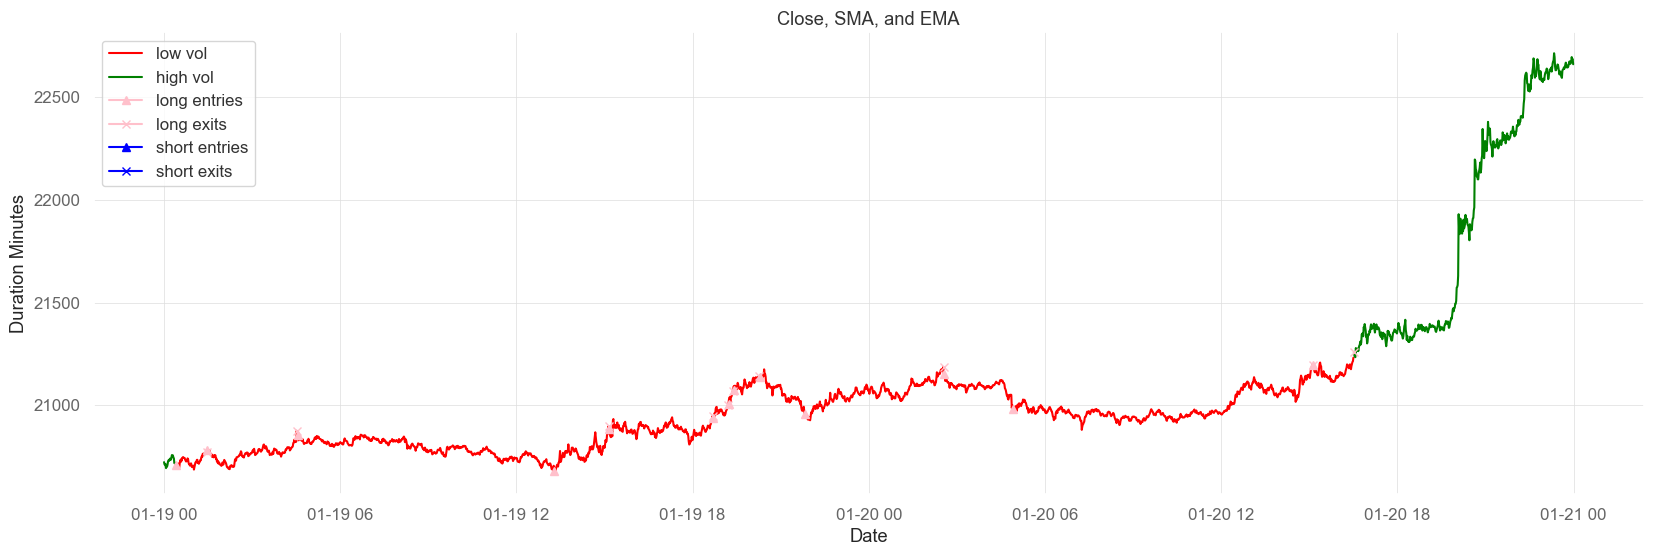

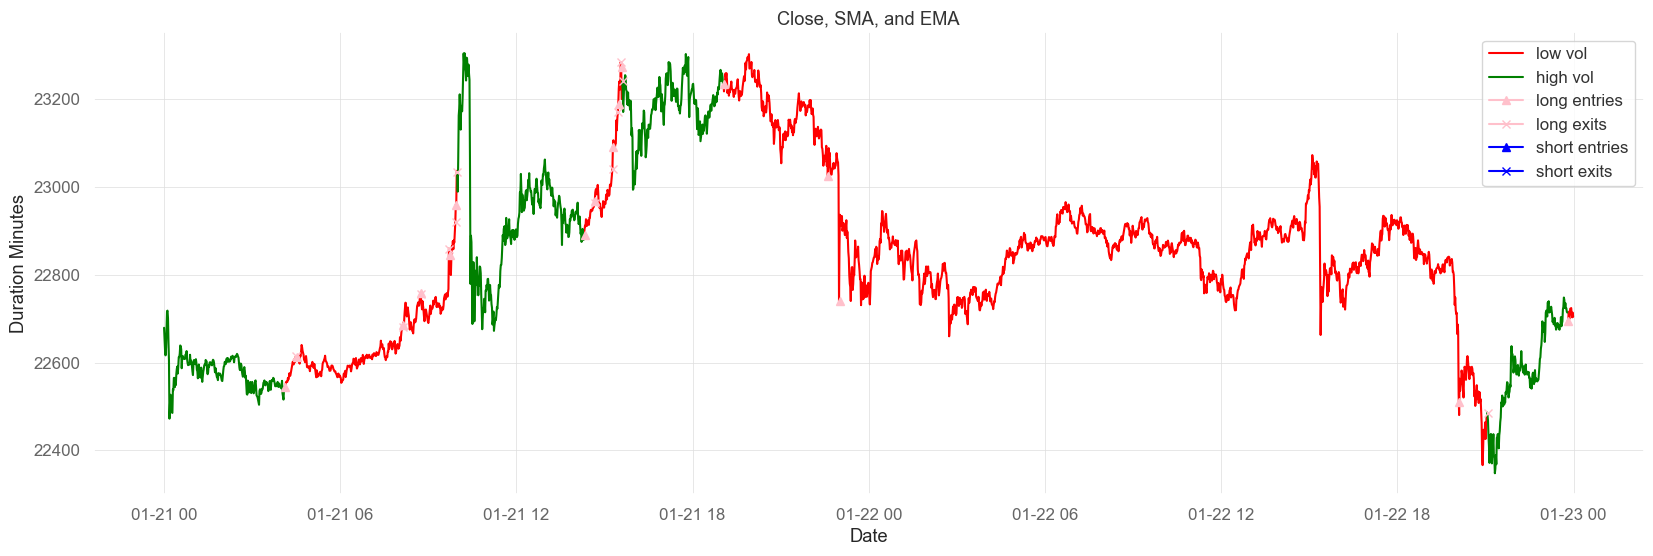

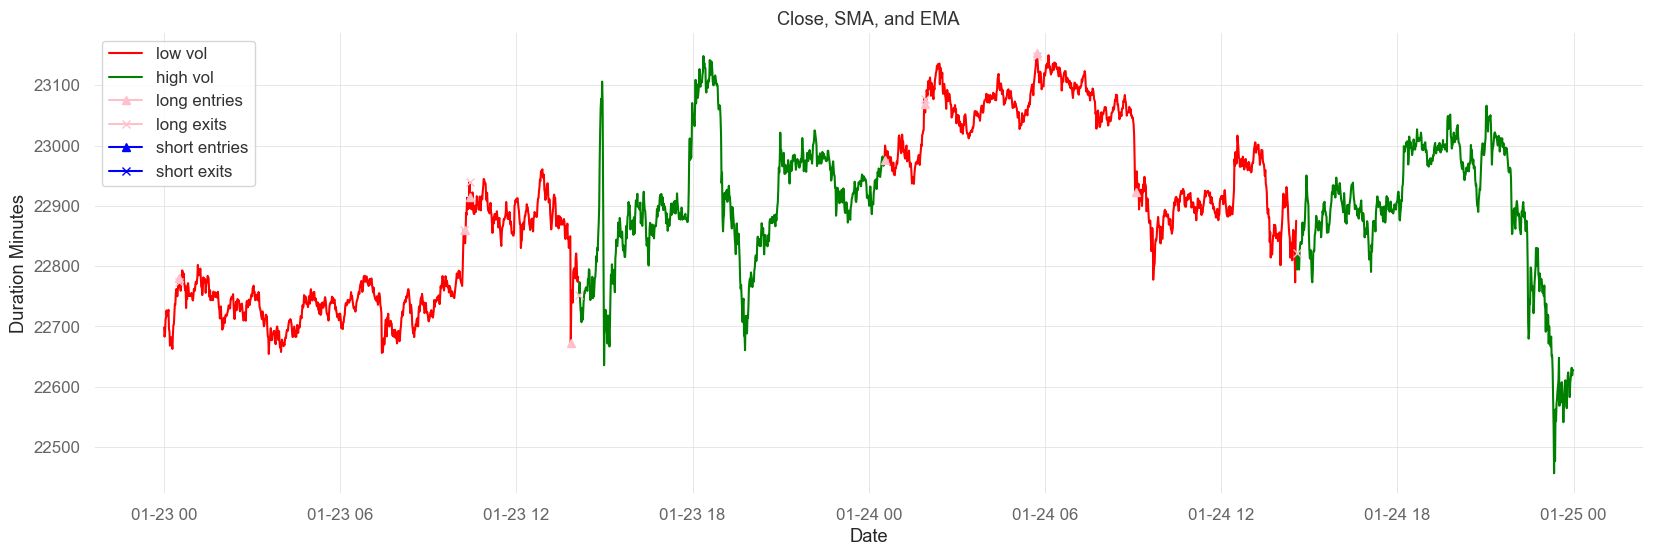

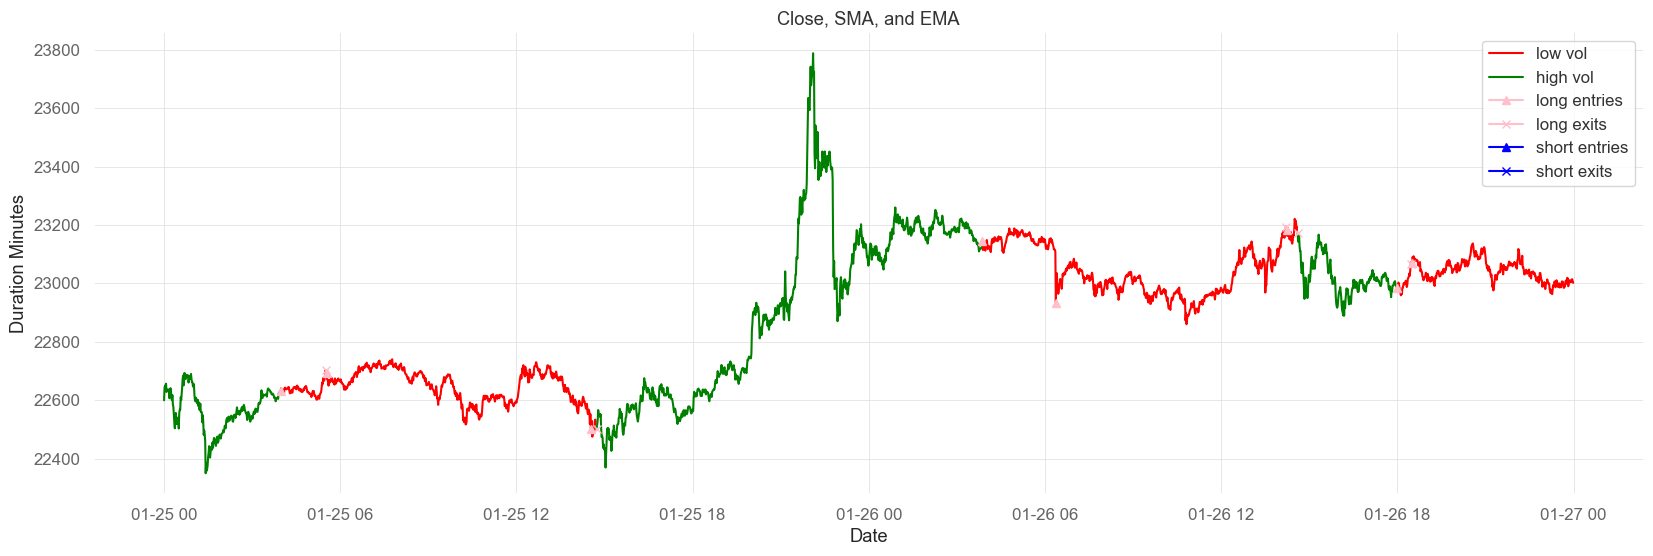

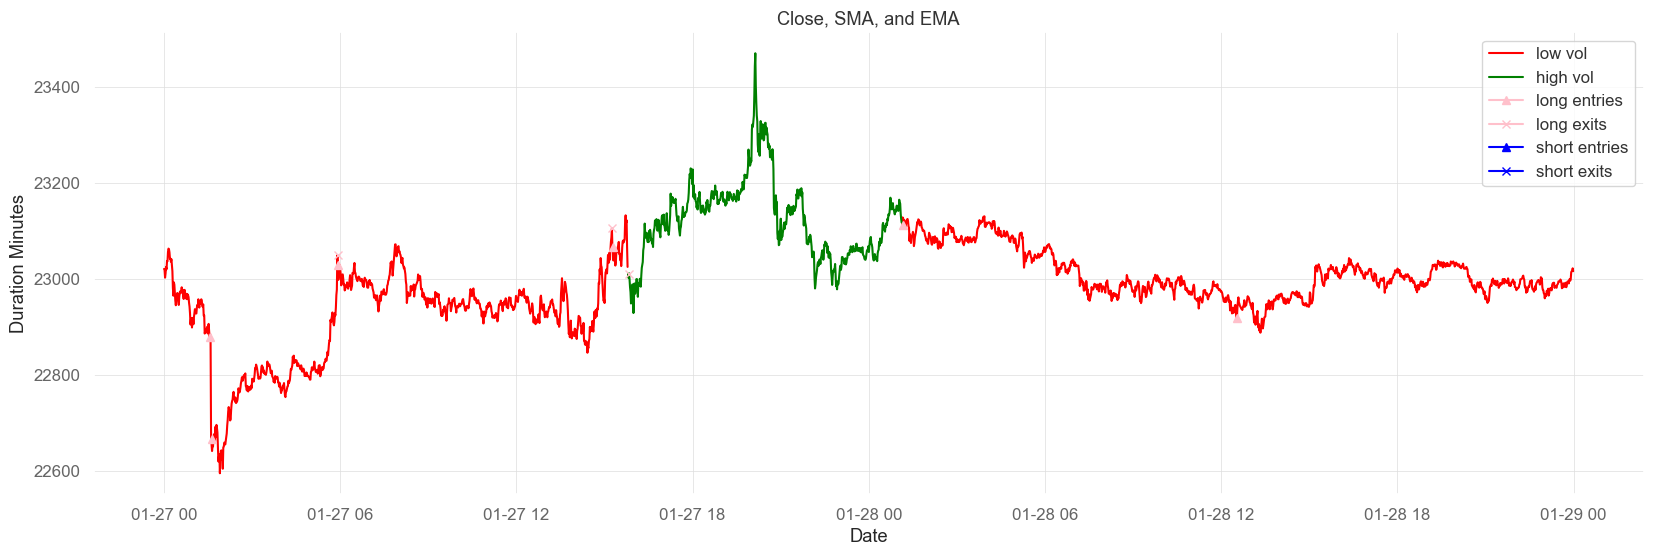

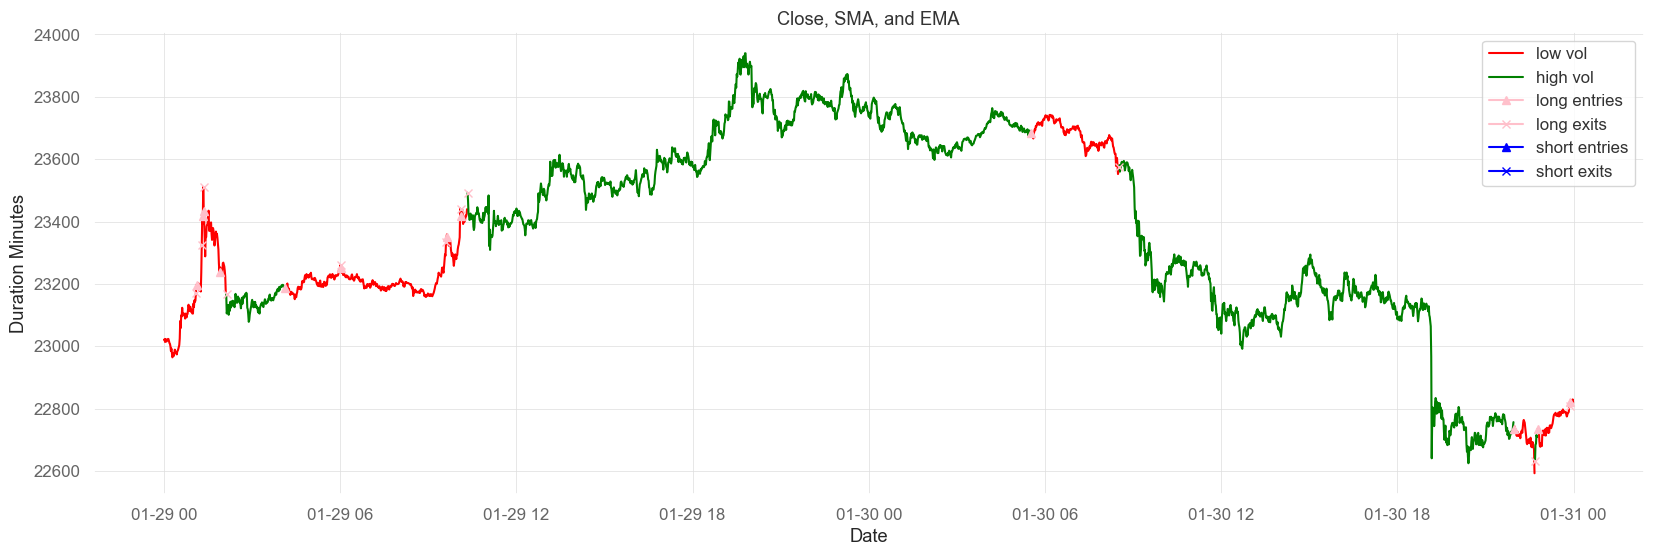

In [76]:
for i in range(15):
    start = f'2023-1-{(i*2)+1}'
    end = f'2023-1-{(i+1)*2}'
    # start = f'2023-01-01'
    # end = f'2023-02-01'

    plot_sample = trade_analysis.loc[start:end].copy()

    # print(plot_sample.to_markdown())
    

    #red = -1
    
    plot_sample['low vol'] = np.where(plot_sample['cross'] == -1, plot_sample['Close'], None )
    plot_sample['high vol'] = np.where(plot_sample['cross'] == 1,  plot_sample['Close'], None)

    # plot_sample['psar buy'] = np.where(plot_sample['Signal'] != 1, None, plot_sample['Close'])
    # plot_sample['psar sell'] = np.where(plot_sample['Signal'] != -1, None, plot_sample['Close'])

    # print(plot_sample.to_markdown())

    # Plot the Close, SMA, and EMA
    plt.figure(figsize=(20, 6))
    plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
    plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')
    # plt.plot(plot_sample.index, plot_sample['psar buy'], label = 'psar buy', marker = 'o', color = 'pink')
    # plt.plot(plot_sample.index, plot_sample['psar sell'], label = 'psar sell', marker = 'o', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['long_entries'], label = 'long entries', marker = '^', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['long_exits'], label = 'long exits', marker = 'x', color = 'pink')
    plt.plot(plot_sample.index, plot_sample['short_entries'], label = 'short entries', marker = '^', color = 'blue')
    plt.plot(plot_sample.index, plot_sample['short_exits'], label = 'short exits', marker = 'x', color = 'blue')
    # plt.plot(plot_sample.index, plot_sample['Close'], label='close', linestyle='--', color = 'black')
    # plt.plot(plot_sample.index, plot_sample['sma'], label=f'SMA ({sma_window} periods)', linestyle='--', marker='o')
    # plt.plot(plot_sample.index, plot_sample['ema'], label=f'EMA (span={ema_span})', linestyle='--', marker='o')

    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Duration Minutes')
    plt.title('Close, SMA, and EMA')
    plt.legend()

In [ ]:
"""
This has the tp 

Lets do position manager entry style. And you enter in a red period, exit when it turns green 
You enter long or short based off 20 period and 50 period SMA (on 4 hour candles) 4800 min and 12000
Lets start with regular position manager 80 bps down and then add 1/6 1/3 1/2 or maybe we do less initial 
Next step could be changing the 80 bps to something market determined
"""
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    
    trailing_tp = {
        "order_status": "closed",
        "direction": "long",
        "entry price": 10000,
        "trailing_tp_pct": 0.02,
        "tp_pct": 0.03,
    }

    tp_threshold_long = .01
    tp_lag_long = .002
    tp_threshold_short = .01
    tp_lag_short = .002

    n1 = 4800
    n2 = 12000
    
    def _signal(self):
        return self.data.Signal
    
    def _vol(self):
        return self.data.cross
    
    def init(self):
        super().init()
        self.signal = self.I(self._signal)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def bars_since_first_trade(self):
        if len(self.trades) > 0:
            first_trade_entry_bar = self.trades[0].entry_bar
            bars_since_first_trade = len(self.data.Close) - first_trade_entry_bar
            return bars_since_first_trade
        else:
            return 0
    
    def create_trailing_tp(self, action, size, trailing_tp_pct, tp_pct):
        direction = None
        # first execute initial trade
        if action == "buy":
            self.buy(size=size)
            direction = "long"
        elif action == "sell":
            self.sell(size=size)
            direction = "short"

        self.trailing_tp = {
            "order_status": "just_created",
            "direction": direction,
            "entry_price": None,
            "floor_ceiling_price": None,
            "num_orders": 1,
            "trailing_tp_pct": trailing_tp_pct,
            "tp_pct": tp_pct,
        }

    def initialize_tp(self):
        total_size = 0
        total_value = 0
        # get average trade price
        for trade in self.trades:
            # print(f'Past Trade {trade.size} {trade.value}')
            total_size += abs(trade.size)
            total_value += abs(trade.size) * trade.entry_price

        average_price = total_value / total_size

        self.trailing_tp["entry_price"] = average_price
        self.trailing_tp["order_status"] = "happening"

    def maintain_trailing_tp(self):
        
        if self.trailing_tp["order_status"] == "happening":
            
            if self.position.pl_pct > self.trailing_tp["tp_pct"]:
                
                # put in floor order
                if self.trailing_tp["direction"] == "long":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()
                    potential_new_floor_price = self.data.Close * (
                        1 - self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        floor_price = potential_new_floor_price
                    else:
                        floor_price = max(
                            potential_new_floor_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.sell(size=self.position.size, stop=floor_price)
                    self.trailing_tp["num_orders"] += 1

                if self.trailing_tp["direction"] == "short":
                    if self.trailing_tp["num_orders"] > 1:
                        for order in self.orders:
                            order.cancel()

                    potential_new_ceiling_price = self.data.Close * (
                        1 + self.trailing_tp["trailing_tp_pct"]
                    )
                    if self.trailing_tp["floor_ceiling_price"] is None:
                        ceiling_price = potential_new_ceiling_price
                    else:
                        ceiling_price = min(
                            potential_new_ceiling_price,
                            self.trailing_tp["floor_ceiling_price"],
                        )
                    self.buy(size=abs(self.position.size), stop=ceiling_price)
                    self.trailing_tp["num_orders"] += 1
    
    def set_signal(self):
        self.latest_signal_time = self.data.index[-1]
        self.latest_signal = self.signal

    def next(self):
        super().next()

        if self.trailing_tp["order_status"] == "just_created":
            self.initialize_tp()
            self.maintain_trailing_tp()

        elif self.trailing_tp["order_status"] == "happening":
            """
            If we are supposed to be in a trailing tp and then we find
            out that this no position, that means that the order must
            have executed and therefore we are no longer in a trailing tp
            """
            if self.position.size == 0:
                print(f'{self.data.index[-1]} TP Stopped')
                print(self.closed_trades[-1].pl_pct)
                for order in self.orders:
                    order.cancel()
                self.trailing_tp["order_status"] = "closed"
            self.maintain_trailing_tp()

        
        if self.signal != 0:
            self.set_signal()
            # print(f'{self.data.index[-1]} Set Signal')
        
        if self.latest_signal is not None:
            # print(f'{self.data.index[-1]} Signal is not none')
        

            if self.position and self.vol[-1] == 1 and self.lv_blip_start_time is None:
                self.lv_blip_start_time = self.data.index[-1]
            
            if self.lv_blip_start_time is not None:
                
                if self.vol[-1] == -1:
                    self.lv_blip_start_time = None
 
                elif self.lv_blip_start_time + self.lv_blip_threshold > self.data.index[-1]:
                    if self.position.pl_pct > 0:
                        self.position.close()
                        print(f"{self.data.index[-1]} In a Blip but found profit {self.position.pl_pct}")
                        self.lv_blip_start_time = None
                    elif self.lv_blip_start_time + self.lv_blip_break_even_threshold > self.data.index[-1]:
                        self.position.close()
                        print(f"{self.data.index[-1]} In a Blip profit timeout {self.position.pl_pct}")
                        self.lv_blip_start_time = None


            
            
            if not self.position and self.vol[-1] == -1 and self.latest_signal_time + self.signal_threshold > self.data.index[-1]:
                if self.latest_signal == 1:
                    self.create_trailing_tp("buy", .99, self.tp_lag_long, self.tp_threshold_long)
                    print(f'{self.data.index[-1]} Bought')
                    #signal is used now and shouldnt be valid for anything else 
                    
                else:
                    self.create_trailing_tp("sell", .99, self.tp_lag_short, self.tp_threshold_short)
                    print(f'{self.data.index[-1]} Sold')
                
                self.latest_signal_time = self.latest_signal_time - self.signal_threshold
                self.lv_blip_start_time = None
            
            #if we are in a positon in high vol and we get opposite signal
            if self.position and self.vol[-1] == -1 and self.signal != 0:
                
                if self.position.size > 0 and self.signal == -1:
                    print(f'Reversal Time to go short {self.position.pl_pct}')
                    self.position.close()
                    self.create_trailing_tp("sell", .99, self.tp_lag_short, self.tp_threshold_short)
                    self.latest_signal_time = self.latest_signal_time - self.signal_threshold
                elif self.position.size < 0 and self.signal == 1:
                    print(f'Reversal Time to go Long {self.position.pl_pct}')
                    self.position.close()
                    self.create_trailing_tp("buy", .99, self.tp_lag_long, self.tp_threshold_long)
                    self.latest_signal_time = self.latest_signal_time - self.signal_threshold

bt_start = '2023-01-01'
bt_end = '2023-10-01'
params = {
    'tp_threshold_long' :.02,
    'tp_lag_long' :  .005,
    'tp_threshold_short' : .01,
    'tp_lag_short' : .002
}
bt_data = df.loc[bt_start:bt_end].copy()
bt = Backtest(
    bt_data,
    MiniJumper,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=1,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run(**params)
print(stat)
    